In [1]:
# Business problem
# Apply a data reduction technique factor analysis for variable reduction technique 
# and a clustering algorithm to reveal the behavioral segments of credit card holders

# Assume average spending per month if they purchase

require(Hmisc)
require(dplyr)
require(psych)
require(ggplot2)
require(GPArotation)
require(factoextra)
require(cluster)
require(reshape2)
require(tables)

Loading required package: Hmisc
Loading required package: lattice
Loading required package: survival
Loading required package: Formula
Loading required package: ggplot2

Attaching package: ‘Hmisc’

The following objects are masked from ‘package:base’:

    format.pval, units

Loading required package: dplyr

Attaching package: ‘dplyr’

The following objects are masked from ‘package:Hmisc’:

    src, summarize

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: psych

Attaching package: ‘psych’

The following object is masked from ‘package:Hmisc’:

    describe

The following objects are masked from ‘package:ggplot2’:

    %+%, alpha

Loading required package: GPArotation
Loading required package: factoextra
Welcome! Related Books: `Practical Guide To Cluster Analysis in R` at https://goo.gl/13EFCZ
Loading required package: cluster
Loading requi

In [2]:
dataVanilla <- read.csv("/Users/imnfkhri/R/DataByte/AllCaseStudies/Segmentation/CC GENERAL.csv")
str(dataVanilla)

'data.frame':	8950 obs. of  18 variables:
 $ CUST_ID                         : Factor w/ 8950 levels "C10001","C10002",..: 1 2 3 4 5 6 7 8 9 10 ...
 $ BALANCE                         : num  40.9 3202.5 2495.1 1666.7 817.7 ...
 $ BALANCE_FREQUENCY               : num  0.818 0.909 1 0.636 1 ...
 $ PURCHASES                       : num  95.4 0 773.2 1499 16 ...
 $ ONEOFF_PURCHASES                : num  0 0 773 1499 16 ...
 $ INSTALLMENTS_PURCHASES          : num  95.4 0 0 0 0 ...
 $ CASH_ADVANCE                    : num  0 6443 0 206 0 ...
 $ PURCHASES_FREQUENCY             : num  0.1667 0 1 0.0833 0.0833 ...
 $ ONEOFF_PURCHASES_FREQUENCY      : num  0 0 1 0.0833 0.0833 ...
 $ PURCHASES_INSTALLMENTS_FREQUENCY: num  0.0833 0 0 0 0 ...
 $ CASH_ADVANCE_FREQUENCY          : num  0 0.25 0 0.0833 0 ...
 $ CASH_ADVANCE_TRX                : int  0 4 0 1 0 0 0 0 0 0 ...
 $ PURCHASES_TRX                   : int  2 0 12 1 1 8 64 12 5 3 ...
 $ CREDIT_LIMIT                    : num  1000 7000 7500 750

In [3]:
Hmisc::describe(dataVanilla)

dataVanilla 

 18  Variables      8950  Observations
--------------------------------------------------------------------------------
CUST_ID 
       n  missing distinct 
    8950        0     8950 

lowest : C10001 C10002 C10003 C10004 C10005, highest: C19186 C19187 C19188 C19189 C19190
--------------------------------------------------------------------------------
BALANCE 
       n  missing distinct     Info     Mean      Gmd      .05      .10 
    8950        0     8871        1     1564     1948    8.815   23.576 
     .25      .50      .75      .90      .95 
 128.282  873.385 2054.140 4338.564 5909.112 

lowest :     0.000000     0.000199     0.001146     0.001214     0.001289
highest: 16115.596400 16259.448570 16304.889250 18495.558550 19043.138560
--------------------------------------------------------------------------------
BALANCE_FREQUENCY 
       n  missing distinct     Info     Mean      Gmd      .05      .10 
    8950        0       43    0.666   0.8773   0.1986   0.272

In [4]:
# Check out names of all variable
names(dataVanilla)

[1] "CUST_ID"                          "BALANCE"                         
 [3] "BALANCE_FREQUENCY"                "PURCHASES"                       
 [5] "ONEOFF_PURCHASES"                 "INSTALLMENTS_PURCHASES"          
 [7] "CASH_ADVANCE"                     "PURCHASES_FREQUENCY"             
 [9] "ONEOFF_PURCHASES_FREQUENCY"       "PURCHASES_INSTALLMENTS_FREQUENCY"
[11] "CASH_ADVANCE_FREQUENCY"           "CASH_ADVANCE_TRX"                
[13] "PURCHASES_TRX"                    "CREDIT_LIMIT"                    
[15] "PAYMENTS"                         "MINIMUM_PAYMENTS"                
[17] "PRC_FULL_PAYMENT"                 "TENURE"

In [5]:
# See How many missing in a column
colSums(is.na(dataVanilla))

CUST_ID                          BALANCE 
                               0                                0 
               BALANCE_FREQUENCY                        PURCHASES 
                               0                                0 
                ONEOFF_PURCHASES           INSTALLMENTS_PURCHASES 
                               0                                0 
                    CASH_ADVANCE              PURCHASES_FREQUENCY 
                               0                                0 
      ONEOFF_PURCHASES_FREQUENCY PURCHASES_INSTALLMENTS_FREQUENCY 
                               0                                0 
          CASH_ADVANCE_FREQUENCY                 CASH_ADVANCE_TRX 
                               0                                0 
                   PURCHASES_TRX                     CREDIT_LIMIT 
                               0                                1 
                        PAYMENTS                 MINIMUM_PAYMENTS 
                               0                              313 
                PRC_FULL_PAYMENT                           TENURE 
                               0                                0

In [6]:
# To get column with missing value
head(dataVanilla[colSums(is.na(dataVanilla))>0],5)

CREDIT_LIMIT,MINIMUM_PAYMENTS
1000,139.5098
7000,1072.3402
7500,627.2848
7500,NA
1200,244.7912


In [7]:
# Function to treat NA with mean
mia_treat = function(x){
  x[is.na(x)] = mean(x,na.rm=T)
  return(x)
}

# Outlier removal using IQR method
M1_fun <- function(x){
  quantiles <- quantile( x, c(.01, .99 ),na.rm=TRUE )
  x[ x < quantiles[1] ] <- quantiles[1]
  x[ x > quantiles[2] ] <- quantiles[2]
  x
}

In [8]:
# Taking only interested variables
interested <- dataVanilla[,-1]


In [9]:
# Applying NA treatment
interested <-  data.frame(apply(interested, 2, FUN=mia_treat))
#interested[colSums(is.na(interested))>0]

No id variables; using all as measure variables


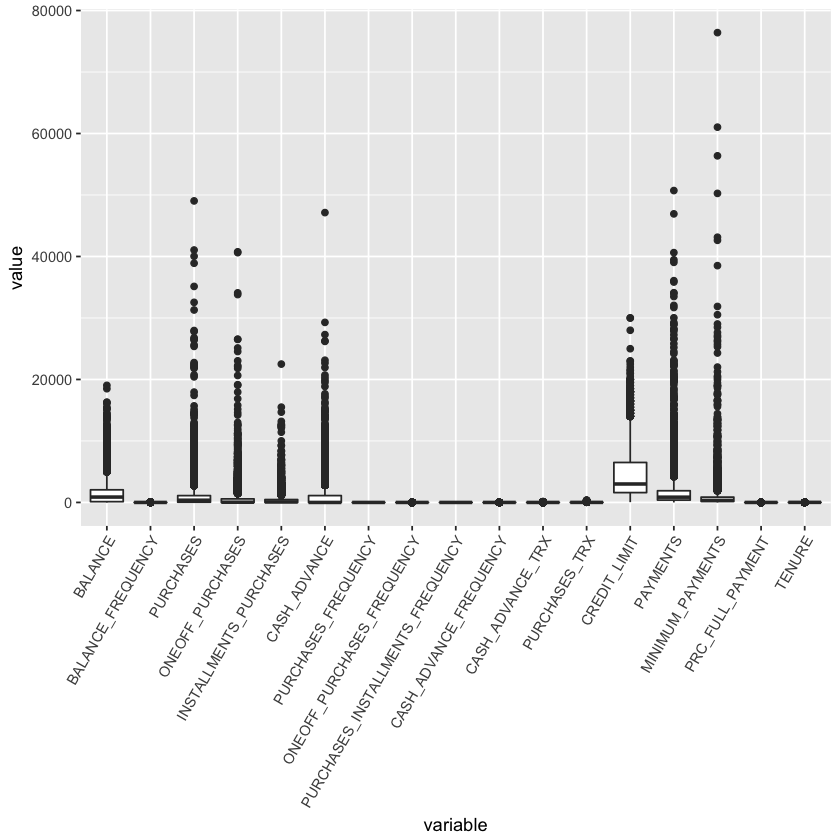

In [10]:
# Looking for outlier(s)
# Using ggplot (Fancier)
# ?melt
# melted is used so that ggplot can do boxplot all in one go
# id.vars is optional, we jst want to see outliers
interestedmelted <- reshape2::melt(interested)
ggplot(interestedmelted) + aes(x = variable, y = value) + geom_boxplot() + theme(axis.text.x = element_text(angle = 60, hjust = 1))

In [11]:
# Generating intellignent KPIs

interested$AVG_MNTH_BAL <- interested$BALANCE/12                                     # Average monthly balance
interested$LIMIT_USAGE <- interested$BALANCE/interested$CREDIT_LIMIT                 # Limit usage ratio
interested$PAY_TO_MIN_PYMNT <- interested$PAYMENTS/interested$MINIMUM_PAYMENTS       # Payment to minimum payment ratio


interested$AVG_AMT_PCHS <- ifelse(interested$PURCHASES_TRX != 0,                     # Average amount per purchase
       interested$AVG_AMT_PCHS <- interested$PURCHASES/ interested$PURCHASES_TRX,
       interested$AVG_AMT_PCHS <- 0)

interested$AVG_CASH_ADV <- ifelse(interested$CASH_ADVANCE_TRX == 0,                  # Average amount per cash advance
       interested$AVG_CASH_ADV <- 0,
       interested$AVG_CASH_ADV <- interested$CASH_ADVANCE/ interested$CASH_ADVANCE_TRX )

# Purchases type
# 1 - One off
# 2 - Installments
# 3 - Both
interested$ONEOFF_CUST <- ifelse(interested$ONEOFF_PURCHASES != 0, 1,0)
interested$INST_CUST  <- ifelse(interested$INSTALLMENTS_PURCHASES != 0, 1, 0)
interested$BOTH_CUST <- ifelse(interested$ONEOFF_PURCHASES != 0 & interested$INSTALLMENTS_PURCHASES != 0, 1, 0)


In [12]:
# Treating outliers
interested <- M1_fun( interested )

No id variables; using all as measure variables


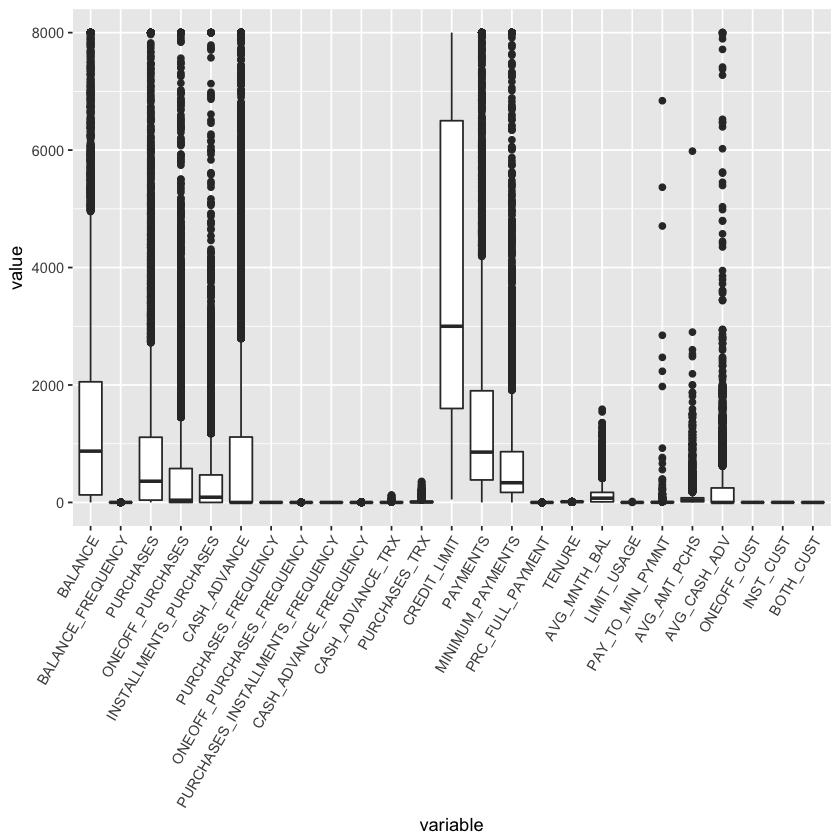

In [13]:
# Final overview of data
interestedmelted <- reshape2::melt(interested)
ggplot(interestedmelted) + aes(x = variable, y = value) + geom_boxplot() + theme(axis.text.x = element_text(angle = 60, hjust = 1))

The estimated weights for the factor scores are probably incorrect.  Try a different factor extraction method.


[1] 5.95486609 4.85967513 2.08067509 1.66020574 1.35161945 1.10759895
 [7] 1.01206362 0.99435516 0.95721237 0.79951293 0.76624347 0.62531484
[13] 0.51227231 0.43854014 0.38246973 0.33710138 0.24206604 0.22984139
[19] 0.18994493 0.17472125 0.15787381 0.09727829 0.03324305 0.01881353
[25] 0.01649131

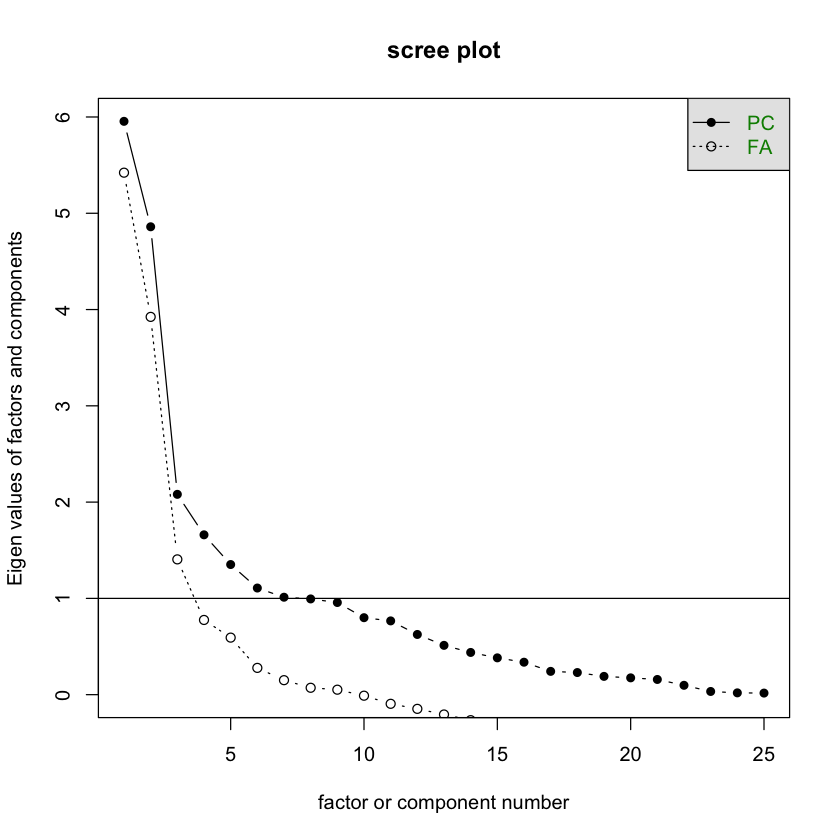

In [14]:
# Generating correlation matrix
corMat <- cor(interested)

psych::scree(corMat, factors=T, pc=T, main="scree plot", hline=NULL, add=FALSE) ### SCREE PLOT

eigen(corMat)$values                                                     ### EIGEN VALUES
eigen_values <- dplyr::mutate(data.frame(eigen(corMat)$values)
                      ,cum_sum_eigen=cumsum(eigen.corMat..values)
                      , pct_var=eigen.corMat..values/sum(eigen.corMat..values)
                      , cum_pct_var=cum_sum_eigen/sum(eigen.corMat..values))

#View(eigen_values)
write.csv(eigen_values, "eigenval.csv")

# Looking at the eigen values that is just below one, deduce that 8 groups will be used

In [15]:
# Factor analysis

FA <- psych::fa(r=corMat, 8, rotate="varimax", fm="ml")               ### CONDUCTING FACTOR ANALYSIS
print(FA)                                                             ### PRINT THE RESULTS
FA_SORT <- psych::fa.sort(FA)                                         ### SORTING THE LOADINGS
#ls(FA_SORT)                                                           ### LISTING OUT THE OBJECTS
#FA_SORT$loadings

#FA_SORT$e.values                                                     ### FINDING EIGEN VALUES FROM THE RESULTS
Loadings <- data.frame(FA_SORT$loadings[1:ncol(interested),])         ### CAPTURING ONLY LOADINGS INTO DATA FRAME

write.csv(Loadings, "loading_segment_ass.csv") ### SAVING THE FILE

Factor Analysis using method =  ml
Call: psych::fa(r = corMat, nfactors = 8, rotate = "varimax", fm = "ml")
Standardized loadings (pattern matrix) based upon correlation matrix
                                   ML1   ML3   ML8   ML6   ML2   ML7   ML5
BALANCE                          -0.01  0.12  0.63  0.22  0.73 -0.02  0.03
BALANCE_FREQUENCY                 0.22  0.07  0.46  0.12  0.03  0.15  0.05
PURCHASES                         0.33  0.83  0.00 -0.06  0.10  0.25  0.31
ONEOFF_PURCHASES                  0.13  0.94  0.01 -0.04  0.06  0.29 -0.09
INSTALLMENTS_PURCHASES            0.43  0.35 -0.02 -0.07  0.10  0.03  0.80
CASH_ADVANCE                     -0.12 -0.04  0.13  0.68  0.44 -0.06 -0.02
PURCHASES_FREQUENCY               0.89  0.16 -0.06 -0.14 -0.05  0.29  0.06
ONEOFF_PURCHASES_FREQUENCY        0.16  0.46  0.02 -0.05  0.03  0.75 -0.02
PURCHASES_INSTALLMENTS_FREQUENCY  0.94  0.06 -0.05 -0.11 -0.03 -0.03  0.17
CASH_ADVANCE_FREQUENCY           -0.16 -0.06  0.27  0.84  0.16 -0.03 -0.0

In [16]:
# Scaling data
interestedScaled = data.frame(scale(interested))

In [17]:
# Checking for K value using silhouette method

# Setup for k-means loop 
km.out <- list()
sil.out <- list()
x <- vector()
y <- vector()

minClust <- 5       # Hypothesized minimum number of segments
maxClust <- 10      # Hypothesized maximum number of segments

# Compute k-means clustering over various clusters, k, from minClust to maxClust
for (centr in minClust:maxClust) {
  i <- centr-(minClust-1)               # relevels start as 1, and increases with centr
  set.seed(11)                          # For reproducibility
  km.out[i] <- list(kmeans(interestedScaled, centers = centr))
  sil.out[i] <- list(silhouette(km.out[[i]][[1]], dist(interestedScaled)))
  # Used for plotting silhouette average widths
  x[i] = centr  # value of k
  y[i] = summary(sil.out[[i]])[[4]]  # Silhouette average width
}

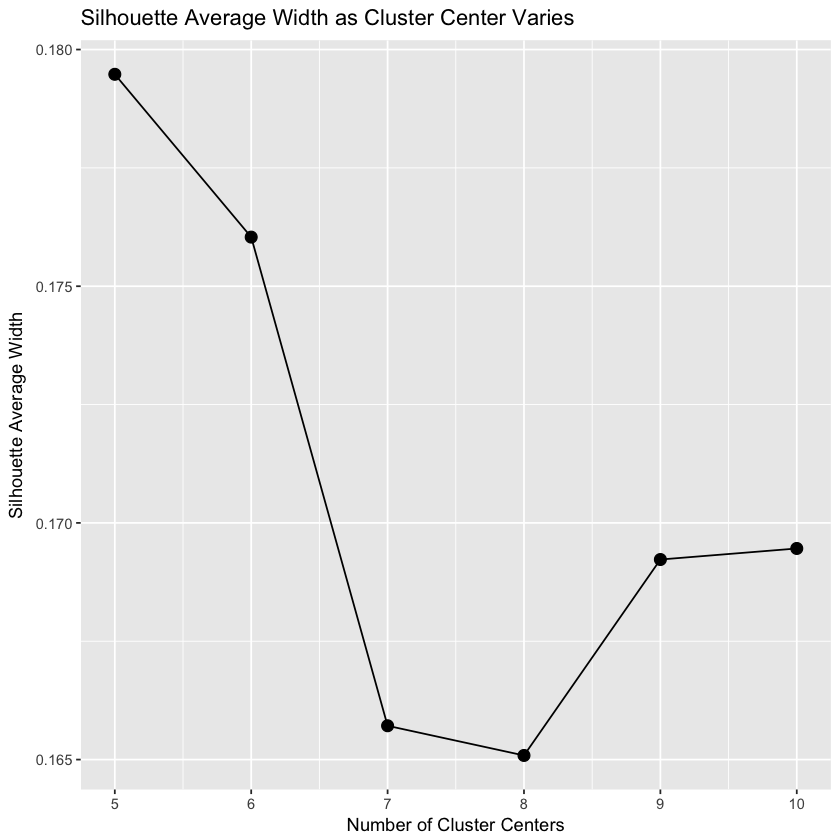

In [18]:
#Next, we plot the silhouette average widths for the choice of clusters. The best cluster is the one with the 
#largest silhouette average width, in this case 7 or 9 clusters can be used

# Plot silhouette results to find best number of clusters; closer to 1 is better
ggplot(data = data.frame(x, y), aes(x, y)) + 
  geom_point(size=3) + 
  geom_line() +
  xlab("Number of Cluster Centers") +
  ylab("Silhouette Average Width") +
  ggtitle("Silhouette Average Width as Cluster Center Varies")

In [39]:
maxSilRow <- which.max(y)          # Row number of max silhouette value
optimalClusters <- x[maxSilRow]    # Number of clusters
km.out.best <- km.out[[maxSilRow]] # k-means output of best cluster

km.out.best2 <- km.out[[3]] # From scree & Eigen analysis #>7
km.out.best3 <- km.out[[4]] # 8
km.out.best4 <- km.out[[5]] # 9

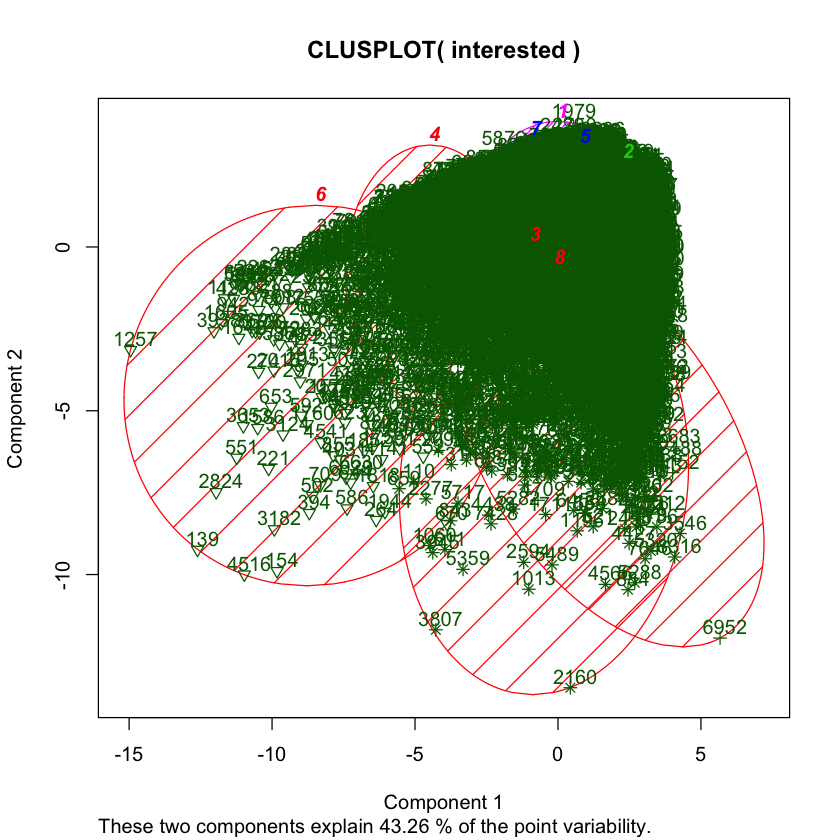

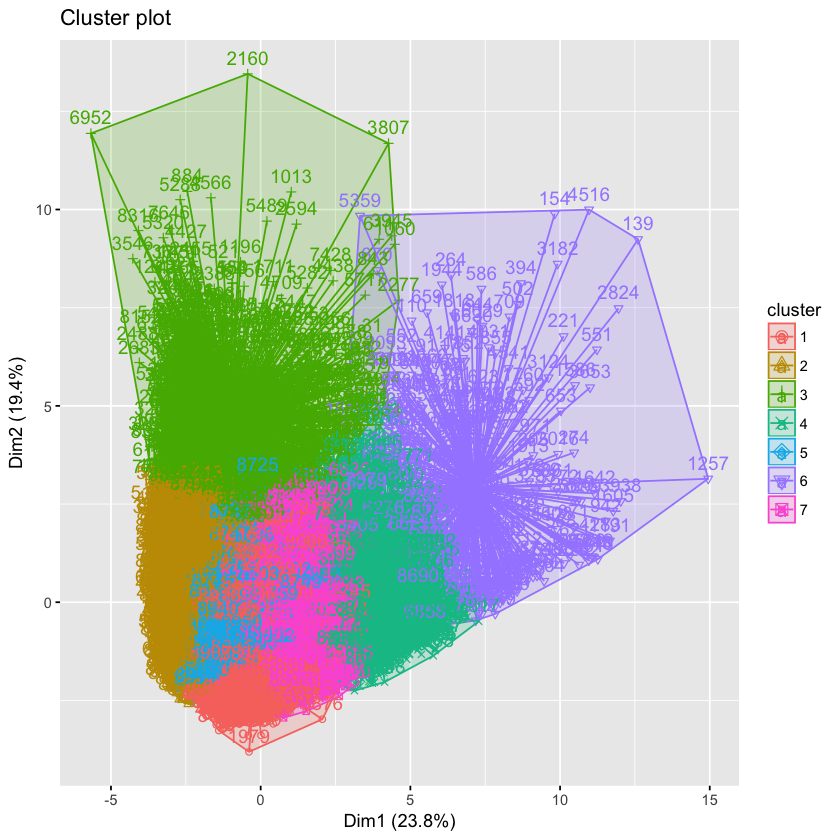

In [40]:
# for 8 centroid
cluster::clusplot(interested, km.out.best3$cluster, color = T, shade = T, lines = 6, labels = 2)
factoextra::fviz_cluster(km.out.best2, data = interested, star.plot = T, ggtheme = theme_gray())

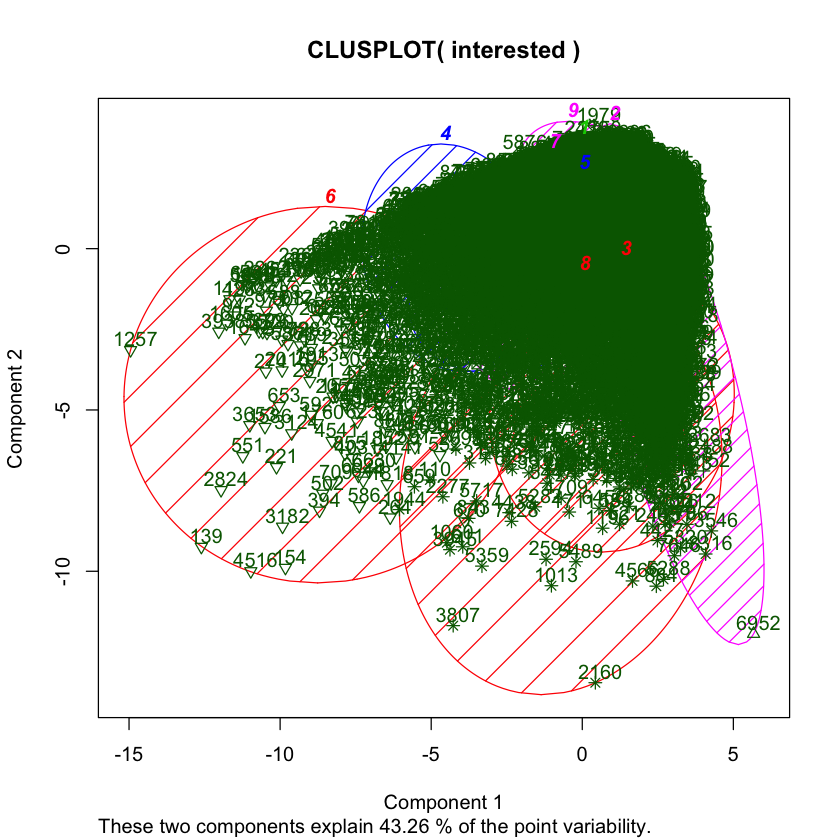

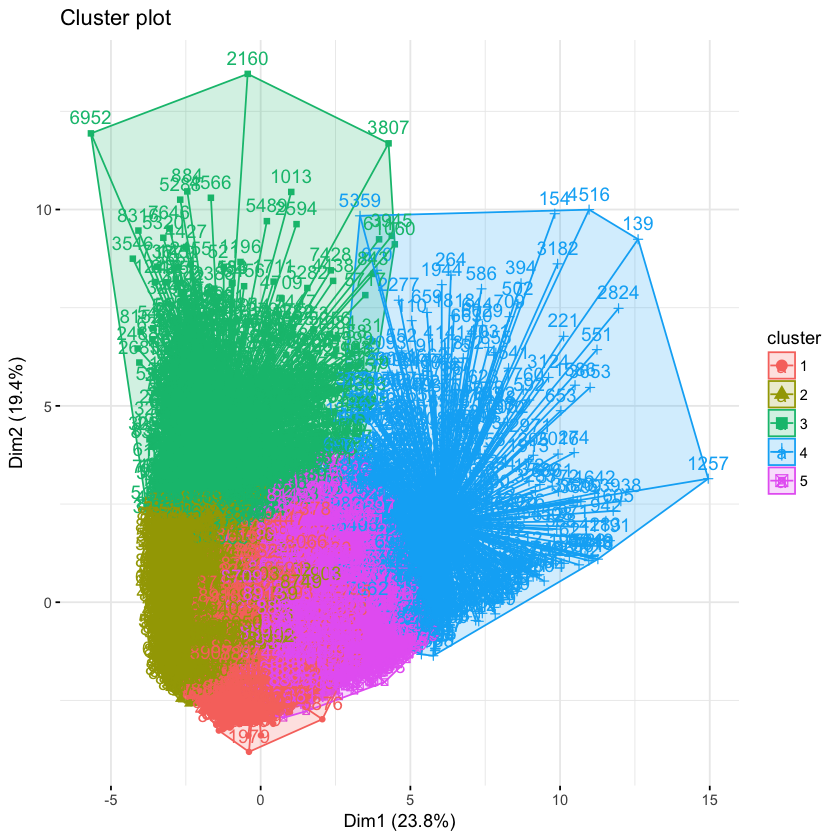

In [41]:
# For 9 centroid
cluster::clusplot(interested, #dataframe
         km.out.best4$cluster, #clusterdata
         color = TRUE,        #color
         shade = TRUE,        # Lines in clusters
         lines = 6,           # lines connecting centroids
         labels = 2           # Labels clusters and cases
)

factoextra::fviz_cluster(km.out.best, data = interested,
             star.plot = TRUE, # Add segments from centroids to items
             ggtheme = theme_minimal()
)


In [42]:
# Getting the clusters value
treatedCluster7 <- t(km.out.best2$cluster)
treatedClusters9 <- t(km.out.best3$cluster)
treatedCluster8 <- t(km.out.best4$cluster)

In [43]:
# Converting to factor datatype
test1<-cbind(interested,km_clust_7=t(treatedCluster7), km_clust_8=t(treatedCluster8) ,km_clust_9=t(treatedClusters9))
test1$km_clust_7 = factor(test1$km_clust_7)
test1$km_clust_8 = factor(test1$km_clust_8)
test1$km_clust_9 = factor(test1$km_clust_9)
#str(test1)

In [44]:
names(test1)

[1] "BALANCE"                          "BALANCE_FREQUENCY"               
 [3] "PURCHASES"                        "ONEOFF_PURCHASES"                
 [5] "INSTALLMENTS_PURCHASES"           "CASH_ADVANCE"                    
 [7] "PURCHASES_FREQUENCY"              "ONEOFF_PURCHASES_FREQUENCY"      
 [9] "PURCHASES_INSTALLMENTS_FREQUENCY" "CASH_ADVANCE_FREQUENCY"          
[11] "CASH_ADVANCE_TRX"                 "PURCHASES_TRX"                   
[13] "CREDIT_LIMIT"                     "PAYMENTS"                        
[15] "MINIMUM_PAYMENTS"                 "PRC_FULL_PAYMENT"                
[17] "TENURE"                           "AVG_MNTH_BAL"                    
[19] "LIMIT_USAGE"                      "PAY_TO_MIN_PYMNT"                
[21] "AVG_AMT_PCHS"                     "AVG_CASH_ADV"                    
[23] "ONEOFF_CUST"                      "INST_CUST"                       
[25] "BOTH_CUST"                        "km_clust_7"                      
[27] "km_clust_8"                       "km_clust_9"

In [45]:
# from tables::tabular
profile<-tabular(1+BALANCE+BALANCE_FREQUENCY+PURCHASES+ONEOFF_PURCHASES+INSTALLMENTS_PURCHASES+
                           CASH_ADVANCE+PURCHASES_FREQUENCY+ONEOFF_PURCHASES_FREQUENCY+PURCHASES_INSTALLMENTS_FREQUENCY+
                           CASH_ADVANCE_FREQUENCY+CASH_ADVANCE_TRX+PURCHASES_TRX+CREDIT_LIMIT+PAYMENTS+MINIMUM_PAYMENTS+
                           PRC_FULL_PAYMENT+TENURE+AVG_MNTH_BAL+AVG_CASH_ADV+AVG_AMT_PCHS+LIMIT_USAGE+
                   PAY_TO_MIN_PYMNT+ONEOFF_CUST+INST_CUST+BOTH_CUST ~ mean +(mean*km_clust_7)+ (mean*km_clust_8)+(mean*km_clust_9), data=test1)
profile1<-as.matrix(profile)
profile1<-data.frame(profile1)
#View(profile1)
write.csv(profile1,"profile1test1.csv")

In [46]:
profile<-tabular(1~length+(length*km_clust_7)+(length*km_clust_8)+(length*km_clust_9), data=test1)
profile2<-as.matrix(profile)
profile2<-data.frame(profile2)
#View(profile2)
write.csv(profile2, "profiletest2.csv")